<a href="https://colab.research.google.com/github/powerflow77/DeepLearning/blob/main/MLP-SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
! pip install shap

In [64]:
import shap
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LambdaCallback

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [65]:
np.random.seed(511)

num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e
y = y.reshape(-1, 1)

x_train = X[:2000]
y_train = y[:2000]

x_test = X[2000:]
y_test = y[2000:]


print(x_train.shape)
print(x_test.shape)

(2000, 2)
(400, 2)


In [71]:
print_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"[Epoch {epoch}]: {round(logs['loss'], 3)}") if epoch % 100 == 0 else None)

with tf.device('/GPU:0'):
    model = keras.Sequential()
    model.add(layers.Dense(units=64, input_dim=x_train.shape[1], activation='relu', use_bias=True))
    model.add(layers.Dense(units=64, activation='relu', use_bias=True))
    model.add(layers.Dense(units=1))

    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    history = model.fit(x_train, y_train, batch_size=64, epochs=800, verbose=0, callbacks=[print_callback])

[Epoch 0]: 1.583
[Epoch 100]: 0.616
[Epoch 200]: 0.425
[Epoch 300]: 0.411
[Epoch 400]: 0.417
[Epoch 500]: 0.41
[Epoch 600]: 0.403
[Epoch 700]: 0.411


In [72]:
# 모델 구조 확인
#model.summary()

In [73]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 3ms/step - loss: 0.3938


0.39375826716423035

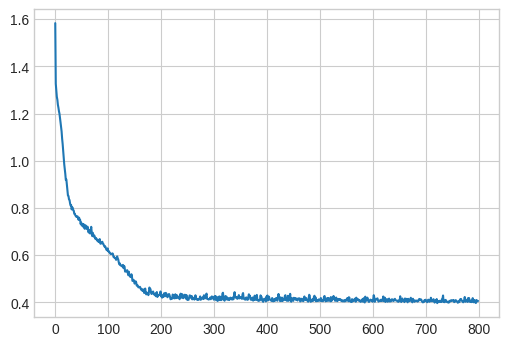

In [74]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.plot(history.history['loss'], label='Training Loss')
plt.show()

In [75]:
x_test[0, :].shape

(2,)

In [76]:
explainer = shap.KernelExplainer(model.predict, x_train)
shap_values = explainer.shap_values(x_test[0, :].reshape(-1, 2))

63/63 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

125/125 [==============================] - 0s 1ms/step


In [77]:
print(shap_values[0][0])

[1.07595572 0.43291217]


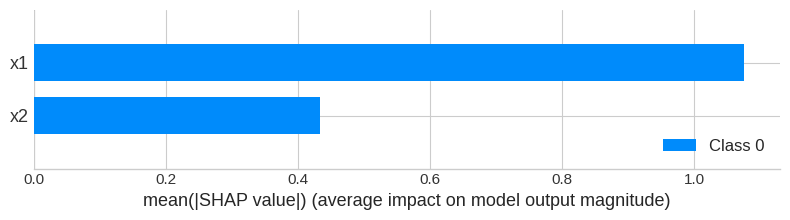

In [78]:
shap.summary_plot(shap_values, x_test[0, :].reshape(-1, 2), feature_names=['x1', 'x2'])